### Dataloader

**Connect to Google Drive to download dataset**

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, combinations
from statistics import mean, stdev

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1ReSvWR3kdB2G1k2ixHvO0FLnhl3K9aYZ"})
downloaded.GetContentFile('data_X.csv')
data_X = pd.read_csv('data_X.csv')
data_X = data_X.drop(columns='Serial_id')

downloaded = drive.CreateFile({'id':"1ezI7FuxttdUHiURtt929qiI83sMHZ27R"})
downloaded.GetContentFile('data_T.csv')
data_T = pd.read_csv('data_T.csv')
data_T = data_T.drop(columns='Serial_id')

In [5]:
# Normalize the input variables
data_X /= data_X.max()

**Divide the dataset to training and validation randomly**

In [6]:
# create random train/valid split
indices = list(range(data_X.shape[0]))
num_training_instances = int(0.8 * data_X.shape[0])
np.random.shuffle(indices)

train_indices = indices[:num_training_instances]
valid_indices = indices[num_training_instances:]

# split the actual data
X_train, X_valid = data_X.iloc[train_indices], data_X.iloc[valid_indices]
Y_train, Y_valid = data_T.iloc[train_indices], data_T.iloc[valid_indices]

### Maximum Likelihood Approach

#### Linear Regression

In [7]:
def RMSE(x, weights, target):
    y = np.dot(x, weights)
    return math.sqrt(np.mean(y - target) ** 2)

In [8]:
def applyPolynomialOrder(x, m):
    x = x.values
    N = len(x[0])

    l = np.full((len(x), 1), 1)

    for order in range(1, m + 1):
        for combination in list(combinations_with_replacement(range(N), order)):
            tmp = x[:, combination]
            p = np.expand_dims(np.prod(tmp, axis=1), axis=1)
            l = np.concatenate((l, p), axis=1)
    return l

In [9]:
def computeWeights(x, target, _lambda = 1, regularized = True):
    # https://long97.blog.csdn.net/article/details/108421700?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.channel_param&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.channel_param
    if regularized:
        xTx = np.dot(x.T, x)
        invterm = np.linalg.inv(_lambda * np.eye(xTx.shape[0]) + xTx)
        weights = np.dot(np.dot(invterm, x.T), target)
    else:
        invterm = np.linalg.inv(np.dot(x.T, x))
        weights = np.dot(np.dot(invterm, x.T), target)
    return weights

In [10]:
def LinearRegression(X_train, Y_train, X_valid, Y_valid, _M = 1, _Gaussian = False, _Sigmoid = False, _Regularized = True):
    Cost_train = []
    Cost_valid = []
    Weights = []
    m = 0

    for m in range(1, _M + 1):
        # Training
        x_t = X_train

        if _Gaussian:
            x_t = applyGaussian(x_t)
        elif _Sigmoid:
            x_t = applySigmoid(x_t)
        else:
            x_t = applyPolynomialOrder(x_t, m)

        # Set regularized = True as default to prevent singular matrix inverse error.
        weights = computeWeights(x_t, Y_train, _Regularized)
        Weights.append(weights)

        cost_train = RMSE(x_t, weights, Y_train)
        Cost_train.append(cost_train)

        # Validation
        x_v = X_valid

        if _Gaussian:
            x_v = applyGaussian(x_v)
        elif _Sigmoid:
            x_v = applySigmoid(x_v)
        else:
            x_v = applyPolynomialOrder(x_v, m)

        cost_valid = RMSE(x_v, weights, Y_valid)
        Cost_valid.append(cost_valid)

    return Cost_train, Cost_valid, Weights

In [11]:
Cost_train, Cost_valid, Weights = LinearRegression(X_train, Y_train, X_valid, Y_valid, 2)

In [12]:
for i in range(1, 3):
    print("M = ", i, ", training error:", Cost_train[i-1], ", validation error:", Cost_valid[i-1])

M =  1 , training error: 0.0005140167677501864 , validation error: 0.0023106298863022484
M =  2 , training error: 0.00022176323538085685 , validation error: 0.002483574990422217


In [13]:
print(X_train.columns)
print(Weights[0])

Index(['GRE_score', 'TOFEL_score', 'University_rating', 'SOP', 'LOR ', 'CGPA',
       'Research'],
      dtype='object')
[[-0.20560671]
 [ 0.11444135]
 [ 0.21293897]
 [ 0.1308546 ]
 [ 0.09056928]
 [ 0.11439221]
 [ 0.43985194]
 [ 0.0515844 ]]


In [25]:
print(Weights[1])

[[-1.85863374]
 [ 6.11104602]
 [-1.58163423]
 [ 0.15413275]
 [-0.50502966]
 [ 0.28851679]
 [ 0.54333375]
 [-2.6306552 ]
 [-0.62413437]
 [-1.52341625]
 [-0.11041452]
 [ 1.51524991]
 [ 0.6273461 ]
 [-7.32002854]
 [ 2.80596566]
 [-1.09355813]
 [ 0.04214218]
 [ 0.74371821]
 [-0.16602873]
 [ 0.7686077 ]
 [ 6.39597288]
 [ 0.02840861]
 [ 0.53736669]
 [-0.2997792 ]
 [-0.36359679]
 [ 0.1132395 ]
 [-0.34706119]
 [ 0.16746312]
 [-0.65736641]
 [-1.4898756 ]
 [ 0.12678768]
 [-0.79088025]
 [-0.10253465]
 [ 2.43955529]
 [ 5.8971264 ]
 [-6.87908304]]


#### Gaussian Basis Function

In [14]:
def gaussianFunction(x, mu, sigma):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

In [15]:
def applyGaussian(x):
    x = x.values
    
    for c in range(len(x[0])):
        column = [col[c] for col in x]
        mean = sum(column) / len(column)
        std = stdev(column)

    column = [gaussianFunction(column[i], mean, std) for i in range(len(column))]

    for i in range(0, len(column)):
        x[i][c] = column[i]
    
    return x

In [16]:
Cost_train, Cost_valid, Weights = LinearRegression(X_train, Y_train, X_valid, Y_valid, _Gaussian = True)

In [17]:
print("Gaussian - training error:", Cost_train[0], ", validation error:", Cost_valid[0])

Gaussian - training error: 0.0013891708657683601 , validation error: 0.003336239225609239


#### Sigmoidal Basis Function

In [18]:
def sigmoidFunction(x):
    return 1.0 / (1.0 + math.exp(-x))

In [19]:
def applySigmoid(x):
    x = x.values
    
    for c in range(len(x[0])):
        column = [col[c] for col in x]

    column = [sigmoidFunction(column[i]) for i in range(len(column))]

    for i in range(0, len(column)):
        x[i][c] = column[i]
    
    return x

In [20]:
Cost_train, Cost_valid, Weights = LinearRegression(X_train, Y_train, X_valid, Y_valid, _Sigmoid = True)

In [21]:
print("Sigmoid - training error:", Cost_train[0], ", validation error:", Cost_valid[0])

Sigmoid - training error: 0.0011235875268768294 , validation error: 0.0031850896293164127


### 5-fold Cross Validation

In [22]:
num_folds = 5

X_train_folds = np.array_split(data_X, num_folds)
Y_train_folds = np.array_split(data_T, num_folds)

Cost_train_f = []
Cost_valid_f = []

for i in range(num_folds):
    X_train_f, X_valid_f = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:]), X_train_folds[i]
    Y_train_f, Y_valid_f = np.concatenate(Y_train_folds[:i] + Y_train_folds[i+1:]), Y_train_folds[i]

    Cost_train, Cost_valid, Weights = LinearRegression(pd.DataFrame(X_train_f), pd.DataFrame(Y_train_f), pd.DataFrame(X_valid_f), pd.DataFrame(Y_valid_f), 2)
    Cost_train_f.append(Cost_train[1])
    Cost_valid_f.append(Cost_valid[1])

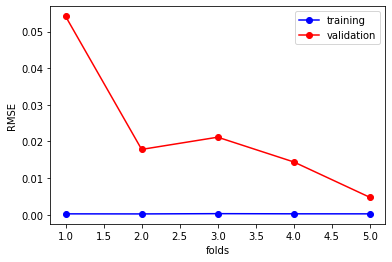

In [23]:
plt.plot([i for i in range(1, num_folds + 1)], Cost_train_f, '-bo', label='training')
plt.plot([i for i in range(1, num_folds + 1)], Cost_valid_f, '-ro', label='validation')

plt.legend(loc='best')
plt.xlabel('folds')
plt.ylabel('RMSE')
plt.show()

### Maximum A Posterior Approach

In [26]:
# https://stats.stackexchange.com/questions/367485/map-estimation-as-regularisation-of-mle
# https://stats.stackexchange.com/questions/347530/why-is-the-regularization-term-added-to-the-cost-function-instead-of-multipli/347534#347534

# MAP
Cost_train, Cost_valid, Weights = LinearRegression(X_train, Y_train, X_valid, Y_valid, 2, _Regularized = True)
print("MAP", "training error:", Cost_train[1], ", validation error:", Cost_valid[1])

# ML
Cost_train, Cost_valid, Weights = LinearRegression(X_train, Y_train, X_valid, Y_valid, 2, _Regularized = False)
print("ML", "training error:", Cost_train[1], ", validation error:", Cost_valid[1])

MAP training error: 0.0003570744413858093 , validation error: 0.0023493203528307024
ML training error: 0.11558635628263877 , validation error: 0.11756318068829154
